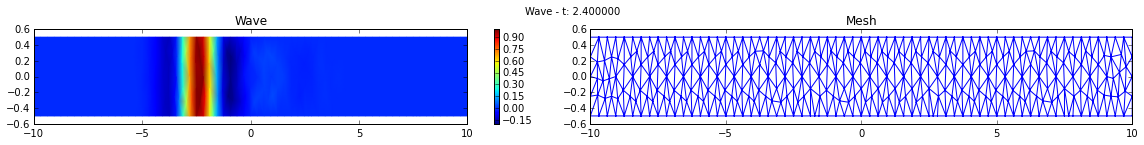

In [ ]:
%matplotlib inline                                                                                                                                                                                                                                            
%run /home/fenics/fenics-matplotlib.py                                                                                                                                                                                                                        
from dolfin import *; from mshr import *; from IPython.display import display, clear_output; import time
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)

import numpy as np

set_log_active(False)

def plot_compact(u, t, stepcounter): # Compact plot utility function
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, Q); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 2)
        plt.subplot(1, 2, 1); mplot_function(uEuclidnorm); plt.title("Wave") # Plot norm of velocity
        plt.colorbar(); # plt.axis(G)
        plt.subplot(1, 2, 2);
        plt.triplot(mesh2triang(mesh)); plt.title("Mesh") # Plot mesh
        plt.suptitle("Wave - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True); display(pl)   
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

Q = FunctionSpace(mesh, "CG", 1); W = Q * Q; h = CellSize(mesh);
(p, q) = TestFunctions(W); w = Function(W); (u, v) = (w[0], w[1]);
u0 = Function(Q); v0 = Function(Q);

t, T = 0., 5.;
k = 0.05;
a = 1;

def boundary(x, on_boundary):  # define the Dirichlet boundary                                                                                                                                                                                                  
    return on_boundary

option = 1;
if option==0:
    ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t-x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh)
if option==1:
    ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh)

bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

u0 = ue;
v0 = ve;

theta = 0.5;
while t < T: # Time-stepping loop                                                                                                                                                                                                                               
    vm = theta*v + (1.0-theta)*v0;
    um = theta*u + (1.0-theta)*u0;
    ru=(u-u0)/k*p*dx - vm*p*dx
    rv=(v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
    r = ru + rv;
    ue.t = t;
    ve.t = t;
    solve(r==0, w, bcs);
    
    # Shift to next timestep                                                     
    u0 = project(u, Q);
    v0 = project(v, Q);

    # visualize the solution
    pl, ax = plt.subplots();
    plot_compact(u, t, 0)
    plt.close();
    t += k;